## Fine-tune Llama 2 for Sentiment Analysis

The FinancialPhraseBank dataset is a comprehensive collection that captures the sentiments of financial news headlines from the viewpoint of a retail investor. Comprising two key columns, namely "Sentiment" and "News Headline," the dataset effectively classifies sentiments as either negative, neutral, or positive. This structured dataset serves as a valuable resource for analyzing and understanding the complex dynamics of sentiment in the domain of financial news. It has been used in various studies and research initiatives, since its inception in the work by Malo, P., Sinha, A., Korhonen, P., Wallenius, J., and Takala, P.  "Good debt or bad debt: Detecting semantic orientations in economic texts.", published in the Journal of the Association for Information Science and Technology in 2014.

* accelerate is a distributed training library for PyTorch by HuggingFace. It allows you to train your models on multiple GPUs or CPUs in parallel (distributed configurations), which can significantly speed up training in presence of multiple GPUs (we won't use it in our example).
* peft is a Python library by HuggingFace for efficient adaptation of pre-trained language models (PLMs) to various downstream applications without fine-tuning all the model's parameters. PEFT methods only fine-tune a small number of (extra) model parameters, thereby greatly decreasing the computational and storage costs.
* bitsandbytes by Tim Dettmers, is a lightweight wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and quantization functions. It allows to run models stored in 4-bit precision: while 4-bit bitsandbytes stores weights in 4-bits, the computation still happens in 16 or 32-bit and here any combination can be chosen (float16, bfloat16, float32, and so on).
* transformers is a Python library for natural language processing (NLP). It provides a number of pre-trained models for NLP tasks such as text classification, question answering, and machine translation.
* trl is a full stack library by HuggingFace providing a set of tools to train transformer language models with Reinforcement Learning, from the Supervised Fine-tuning step (SFT), Reward Modeling step (RM) to the Proximal Policy Optimization (PPO) step.

In [ ]:
## Installations and imports

In [1]:
!pip install -q -U "torch==2.1.2" tensorboard

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
!pip install -q -U "transformers==4.36.2" "datasets==2.16.1" "accelerate==0.26.1" "bitsandbytes==0.42.0"

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
!pip install -q -U git+https://github.com/huggingface/trl@a3c5b7178ac4f65569975efadc97db2f3749c65e
!pip install -q -U git+https://github.com/huggingface/peft@4a1559582281fc3c9283892caea8ccef1d6f5a4f

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release 

## Import and Initialization
Import libraries and testing the available GPUs


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In the following cell there are all the other imports for running the notebook

In [5]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
import torch.nn as nn
from peft import LoraConfig, PeftConfig


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
print(f"pytorch version {torch.__version__}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

pytorch version 2.1.2+cu121
working on cuda:0


In [1]:
#### Import libs 
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Preparing the data and the core evaluation functions

The code in the next cell performs the following steps:

1. Reads the input dataset from the all-data.csv file, which is a comma-separated value (CSV) file with two columns: sentiment and text.
2. Splits the dataset into training and test sets, with 300 samples in each set. The split is stratified by sentiment, so that each set contains a representative sample of positive, neutral, and negative sentiments.
3. Shuffles the train data in a replicable order (random_state=10)
4. Clean text (remove url, stopwords, non-word, shortword)
5. Transforms the texts contained in the train and test data into prompts to be used by Llama: the train prompts contains the expected answer we want to fine-tune the model with

This prepares in a single cell train_data, eval_data and test_data datasets to be used in our fine tuning.

In [2]:

from libs.data_processor import DATA_PROCESSOR

filename = "../../data/all-data.csv"
MAXLENGTH = 128
data_processor = DATA_PROCESSOR(maxlen = MAXLENGTH, prompt_mode = True)
data_processor.read_csv(filename)


/home/iav1hc/miniconda3/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/iav1hc/miniconda3/envs/test/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
data_processor.X_train_org

,sentiment,text
3683,neutral,Mr Jortikka is president of the base metal div...
163,positive,Both operating profit and net sales for the 12...
4017,negative,Finnish automation solutions developer Cencorp...
1588,positive,Renzo Piano 's building design will be a wonde...
1799,positive,`` We are proud to contribute to the creation ...
...,...,...
1374,neutral,"The dividend will be paid on April 15 , 2008 t..."
3869,neutral,The new shares entitle their holders to divide...
2766,neutral,Activities range from the development of natur...
1798,positive,"According to Bosse , the present cooperation i..."


## Testing the model without fine-tuning

In [ ]:
Use LLAMA2Classifier for preparing model for finetuning phase. The model "NousResearch/Llama-2-7b-chat-hf" is selected since the original Llama2 model requires a Huggingface account and then authorization. It makes our demo more complicated
Before finetuning, we evaluate the performance of the pre-training model "NousResearch/Llama-2-7b-chat-hf" on the test dataset as follows:
1. Maps the sentiment labels to a numerical representation, where 2 represents positive, 1 represents neutral, and 0 represents negative.
2. Calculates the accuracy of the model on the test data.
3. Generates an accuracy report for each sentiment label.
4. Generates a classification report for the model.
5. Generates a confusion matrix for the model.

The model "NousResearch/Llama-2-7b-chat-hf" is hard-coded in the class, but can be reselected with any LLM-GPT. However, they have not tested yet.

In [ ]:
from libs.classifiers.llama2 import LLAMA2Classifier
predictor = LLAMA2Classifier()

predictor.build_model()
predictor.evaluate(data_processor, name = "llama2_org")

/home/iav1hc/miniconda3/envs/test/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
 15%|████████████                                                                   | 137/900 [16:22<1:32:29,  7.27s/it]

## Finetuning model 

PEFTConfig:

The peft_config object specifies the parameters for PEFT. The following are some of the most important parameters:

* lora_alpha: The learning rate for the LoRA update matrices.
* lora_dropout: The dropout probability for the LoRA update matrices.
* r: The rank of the LoRA update matrices.
* bias: The type of bias to use. The possible values are none, additive, and learned.
* task_type: The type of task that the model is being trained for. The possible values are CAUSAL_LM and MASKED_LM.
  
Understanding LoRA parameters to avoid overfitting issues.
* A lower LoRA rank (e.g., 8 or 16) is suitable for fine-tuning on a base model, where the goal is to adapt the model to a specific task or dataset. In this case, the model is not required to learn new concepts, but rather to adjust its existing knowledge to fit the new task.
A higher LoRA rank (e.g., 32 or 64) is more suitable for teaching the model new concepts or adapting it to a significantly different dataset. This is because a higher rank allows the model to learn more complex patterns and relationships in the data.
* Alpha is a scaling parameter that controls the strength of the low-rank approximation. A higher alpha value places more emphasis on the low-rank structure, while a lower value reduces its influence. When adjusting r and alpha, consider their interplay. Increasing r without adjusting alpha can lead to overfitting, while increasing alpha without adjusting r can result in underfitting. A balanced approach involves incrementing r and alpha simultaneously to achieve optimal performance.

In [ ]:
peft_config = LoraConfig(
                lora_alpha=16, 
                lora_dropout=0.1,
                r=32,
                bias="none",
                #target_modules="all-linear",
                target_modules = [
                        "q_proj",
                        #"up_proj",
                        "o_proj",
                        "k_proj",
                        #"down_proj",
                        #"gate_proj",
                        "v_proj"
                        ],
                task_type="CAUSAL_LM",
        )
predictor.train(data_processor=data_processor, peft_config=peft_config)



Map: 100%|██████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 12068.09 examples/s]


Start training .....


/home/iav1hc/miniconda3/envs/test/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,1.002600,0.862645
2,0.812500,0.812189


## Testing after finetuning

In [11]:
predictor.evaluate(data_processor, name = "t5_finetuned", show= True)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


TypeError: evaluate() got an unexpected keyword argument 'show'

In the following cell, we evaluate the results. There is little to be said, it is performing really terribly because the 7b-hf model tends to just predict a neutral sentiment and seldom it detects positive or negative sentiment.

## Testing on a text news - Error Analysis

### Merging weight with pre-trained model
Then we can proceed to merging the weights and we will be using the merged model for our testing purposes.

In [4]:
finetuned_model_path = "./trained_weigths/"
from libs.classifiers.llama2 import LLAMA2Classifier
classifer = LLAMA2Classifier()
classifer.merge_finetuned_model(finetuned_model_path)


/home/iav1hc/miniconda3/envs/test/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.41s/it]


In [16]:
from tqdm import tqdm
X_test = data_processor.X_test_org
y_pred = []
for i in tqdm(range(len(X_test))):
    prompt = X_test.iloc[i]["text"]
    result = classifer.predict(prompt)
    answer = result[0]['generated_text'].split("=")[-1]
    if "positive" in answer:
        y_pred.append("positive")
    elif "negative" in answer:
        y_pred.append("negative")
    elif "neutral" in answer:
        y_pred.append("neutral")
    else:
        y_pred.append("none")
X_test["pred"] =  y_pred

X_test

100%|███████████████████████████████████████████████████████████████████████████████| 900/900 [4:03:18<00:00, 16.22s/it]


,sentiment,text,pred
567,positive,new agreement expands long established coopera...,neutral
1752,positive,adp news finnish handling systems provider car...,positive
995,positive,world biggest magazine paper maker said progra...,neutral
601,positive,january 11 2010 ephc board directors approved ...,positive
568,positive,appointment kaupthing bank aims co ordinate ca...,neutral
...,...,...,...
4219,negative,14 000 customers left powerless,negative
4814,negative,due rapid decrease net sales personnel reducti...,negative
4059,negative,finnish retail software developer aldata solut...,negative
4720,negative,fair value company investment properties went ...,negative


### Save results to an csv for error analysis

In [17]:
X_test.to_csv("x_test_with_result.csv")

### Analysis of the properties from which textes are misclassifed. Firstly look at the number of words

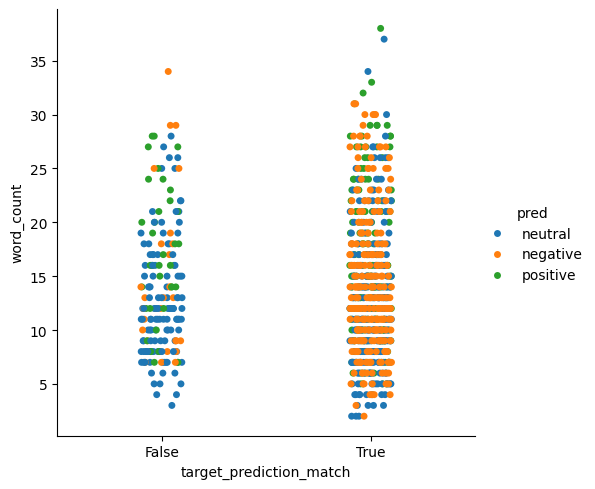

In [43]:
churn_map = {'negative': 0, 'neutral': 1, 'none':1, 'positive': 2}
error_analysis_data = X_test.copy()
predictions = X_test["pred"]
y_test = X_test["sentiment"]
error_analysis_data['prediction'] = list(map(churn_map.get, predictions))
error_analysis_data['target'] = list(map(churn_map.get, y_test))

error_analysis_data['target_prediction_match'] = error_analysis_data['target'].eq(error_analysis_data['prediction'])

from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)

error_analysis_data['word_count'] = X_test["text"].apply(lambda x: len(tokenizer.tokenize(x)) )

error_analysis_data
import seaborn as sns
g = sns.catplot(x="target_prediction_match", y="word_count", hue = "pred",
                data=error_analysis_data)


In [ ]:
### Draw confusion matrix again for more error visualization

Accuracy: 0.790
Accuracy for label 0: 0.860
Accuracy for label 1: 0.867
Accuracy for label 2: 0.643

Classification Report:


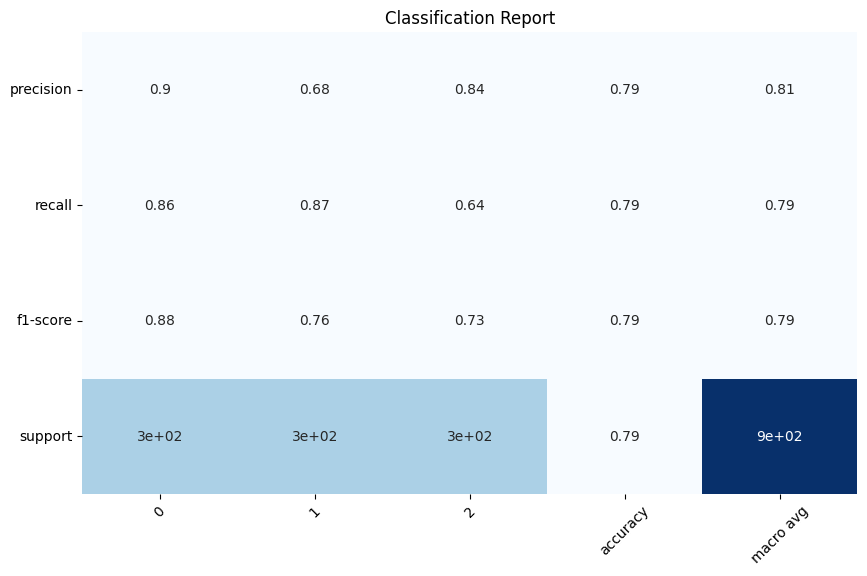

{'0': {'precision': 0.8958333333333334, 'recall': 0.86, 'f1-score': 0.8775510204081632, 'support': 300.0}, '1': {'precision': 0.6788511749347258, 'recall': 0.8666666666666667, 'f1-score': 0.7613469985358713, 'support': 300.0}, '2': {'precision': 0.8427947598253275, 'recall': 0.6433333333333333, 'f1-score': 0.7296786389413988, 'support': 300.0}, 'accuracy': 0.79, 'macro avg': {'precision': 0.8058264226977956, 'recall': 0.79, 'f1-score': 0.7895255526284778, 'support': 900.0}, 'weighted avg': {'precision': 0.8058264226977955, 'recall': 0.79, 'f1-score': 0.7895255526284778, 'support': 900.0}}

Confusion Matrix:


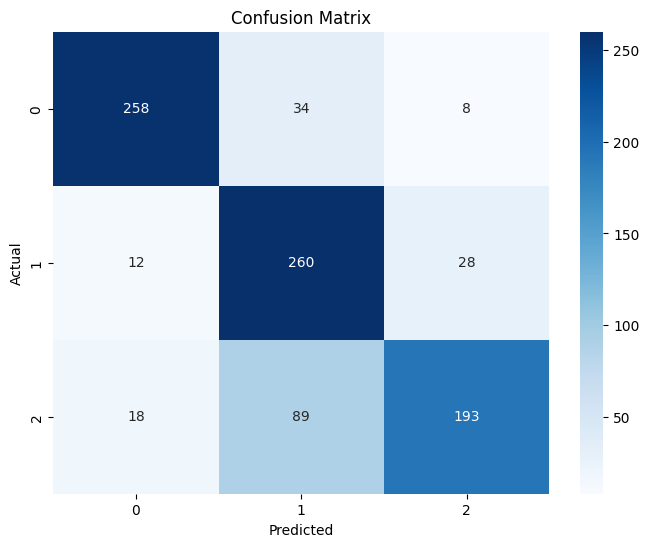

[[258  34   8]
 [ 12 260  28]
 [ 18  89 193]]


In [31]:
import numpy as np
from libs.utils import evaluate
mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
def map_func(x):
    return mapping.get(x, 1)

y_true = np.vectorize(map_func)(y_test)
y_pred = np.vectorize(map_func)(predictions)
evaluate(y_true, y_pred, method="test", show = True)

### Analysis of which words affect the misclassification with actual "positive" but prediction as "neutral". Print out text and words

In [40]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
def count_news(result, news, ys, yd):
    '''
    Input:
        result: a dictionary that will be used to map each pair to its frequency
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    for y, r, text in zip(ys, yd, news):
        tweet_tokens = tokenizer.tokenize(text)
        if y == "positive" and r == "neutral":
            print(text)
            for word in tweet_tokens:
                # define the key, which is the word and label tuple
    
                
                    pair = (word, y)
        
                    # if the key exists in the dictionary, increment the count
                    if pair in result:
                        result[pair] += 1
        
                    # else, if the key is new, add it to the dictionary and set the count to 1
                    else:
                        result[pair] = 1
    ### END CODE HERE ###

    return result
count_news({},X_test["text"],y_test, predictions)

new agreement expands long established cooperation companies involves transfer certain engineering documentation functions larox etteplan
world biggest magazine paper maker said program improve efficiency include closing several least competitive mills would cover company operations resulting annual savings euro200 million us 240 million
appointment kaupthing bank aims co ordinate capital markets activities within group improve overall service clients
past decade gradually divested noncore assets bought several sports equipment makers including california based fitness products international sparks nevada based atec leading maker baseball softball pitching machines
according schmardin nordea likely try win customers pension fund providers
choose efficient best overall value option customers already bidding stage
last year sysopen digia invested ibm product know how building portal trading place systems successfully implemented customer solutions supported
aim annual improvement ruukki 

{('new', 'positive'): 10,
 ('agreement', 'positive'): 4,
 ('expands', 'positive'): 1,
 ('long', 'positive'): 4,
 ('established', 'positive'): 1,
 ('cooperation', 'positive'): 4,
 ('companies', 'positive'): 4,
 ('involves', 'positive'): 1,
 ('transfer', 'positive'): 2,
 ('certain', 'positive'): 2,
 ('engineering', 'positive'): 2,
 ('documentation', 'positive'): 1,
 ('functions', 'positive'): 1,
 ('larox', 'positive'): 1,
 ('etteplan', 'positive'): 1,
 ('world', 'positive'): 1,
 ('biggest', 'positive'): 1,
 ('magazine', 'positive'): 1,
 ('paper', 'positive'): 2,
 ('maker', 'positive'): 2,
 ('said', 'positive'): 7,
 ('program', 'positive'): 2,
 ('improve', 'positive'): 4,
 ('efficiency', 'positive'): 1,
 ('include', 'positive'): 1,
 ('closing', 'positive'): 1,
 ('several', 'positive'): 4,
 ('least', 'positive'): 2,
 ('competitive', 'positive'): 1,
 ('mills', 'positive'): 1,
 ('would', 'positive'): 2,
 ('cover', 'positive'): 1,
 ('company', 'positive'): 17,
 ('operations', 'positive'): 4,
